# Importing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.data_utils import Sequence
import keras
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Reshape, Dense, add, BatchNormalization
from keras.utils import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import cv2
import random, math
from glob import glob
import re
import os, shutil
from tqdm import tqdm 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data

In [3]:
def repcats(f):
    if re.search(r"^[mf]\d",f.lower()):
        f = f.lower()[0]+f[2:]
    return f

def copyfiles(srcs, dsts):
    for i in zip(srcs, dsts):
        shutil.copy(i[0],i[1])


In [4]:
def augment_data(X, Y):
    X, Y = list(X), list(Y)
    image_path = './photos'
    for i in sorted(os.listdir(image_path)):
        image = cv2.imread(image_path + '/' + i,1)
        
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0
        
        #appending normal normal image    
        X.append(img_to_array(image))
        # Image Augmentation
        
        # horizontal flip 
        img1 = cv2.flip(image,1)
        X.append(img_to_array(img1))
        #vertical flip 
        img2 = cv2.flip(image,-1)
        X.append(img_to_array(img2))
        #vertical flip 
        img3 = cv2.flip(image,-1)
        # horizontal flip
        img3 = cv2.flip(img3,1)
        X.append(img_to_array(img3))
        # rotate clockwise 
        img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        X.append(img_to_array(img4))
        # flip rotated image 
        img5 = cv2.flip(img4,1)
        X.append(img_to_array(img5))
        # rotate anti clockwise 
        img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        X.append(img_to_array(img6))
        # flip rotated image 
        img7 = cv2.flip(img6,1)
        X.append(img_to_array(img7))
      
    sketch_path = './sketches'
    for i in sorted(os.listdir(sketch_path)):
        image = cv2.imread(sketch_path + '/' + i,1)
        
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        Y.append(img_to_array(image))
        
        #Image Augmentation
        # horizontal flip 
        img1 = cv2.flip(image,1)
        Y.append(img_to_array(img1))
        #vertical flip 
        img2 = cv2.flip(image,-1)
        Y.append(img_to_array(img2))
        #vertical flip 
        img3 = cv2.flip(image,-1)
        # horizontal flip
        img3 = cv2.flip(img3,1)
        Y.append(img_to_array(img3))
        # rotate clockwise 
        img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        Y.append(img_to_array(img4))
        # flip rotated image 
        img5 = cv2.flip(img4,1)
        Y.append(img_to_array(img5))
        # rotate anti clockwise 
        img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        Y.append(img_to_array(img6))
        # flip rotated image 
        img7 = cv2.flip(img6,1)
        Y.append(img_to_array(img7))

    return X, Y

In [10]:
def read_data(image_path="/content/drive/MyDrive/Colab Notebooks/Applied Data Mining/input/photos/",
              sketch_path="/content/drive/MyDrive/Colab Notebooks/Applied Data Mining/input/sketches/",
              SIZE=256, 
              augmentation=False):
    # image_path = "/content/drive/MyDrive/Colab Notebooks/Applied Data Mining/input/photos/"
    # sketch_path = "/content/drive/MyDrive/Colab Notebooks/Applied Data Mining/input/sketches/"
    img_arrray, sketch_array = [], []
    prev_photo_files = [image_path + i for i in sorted(os.listdir(image_path))]
    prev_sketch_files = [sketch_path + i for i in sorted(os.listdir(sketch_path))]
    for p in ["photos","sketches"]:
        if not os.path.exists("./"+p):
            os.mkdir("./"+p)
    new_photo_files = ['./photos/'+repcats(i) for i in sorted(os.listdir(image_path))]
    new_sketch_files = ['./sketches/'+repcats(i) for i in sorted(os.listdir(sketch_path))]
    copyfiles(prev_photo_files, new_photo_files)
    copyfiles(prev_sketch_files, new_sketch_files)

    my_sketches = sorted(glob("./sketches/*.jpg"))
    my_photos = sorted(glob("./photos/*.jpg"))

    X = []
    Y = []
    for i in zip(my_photos, my_sketches):
        img = load_img(i[0], target_size=(SIZE,SIZE))
        X.append(img_to_array(img)/255.0)
        img = load_img(i[1], target_size=(SIZE,SIZE))
        Y.append(img_to_array(img)/255.0)
      
    if augmentation:
        X, Y = augment_data(X, Y)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [6]:
def get_data(augmentation=False, face2sketch=True):
    # Reads data from the source, performs data augmentation if needed,
    # splits train/test set and return the splits
    X, Y = read_data(augmentation=augmentation)
    if not face2sketch:
        X, Y = Y, X
    train_size = len(X) * 9 // 10
    random.seed(777)
    if not augmentation:
        x_train, x_test, y_train, y_test = \
            train_test_split(X,Y, test_size=0.1)
    else:
        x_train, x_test, y_train, y_test = \
            X[:train_size], X[train_size:], Y[:train_size], Y[train_size:]
    x_train, x_test = np.array(x_train), np.array(x_test)
    y_train, y_test = np.array(y_train), np.array(y_test)
    print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test


In [7]:
import random
SIZE = 256
def compare(model, x_test):
    decoded_img = model.predict(x_test)

    n = 10  # How many images we will display
    inds = random.sample(range(0, len(x_test)), n)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[inds[i]].reshape(SIZE, SIZE, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_img[inds[i]].reshape(SIZE, SIZE, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [8]:
def plot_loss(hist):
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_loss"], label="Validation Loss");
    plt.legend()
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.show()

In [11]:
x_train, x_test, y_train, y_test = get_data(augmentation=True, face2sketch=True)

(1166, 256, 256, 3) (1166, 256, 256, 3) (130, 256, 256, 3) (130, 256, 256, 3)


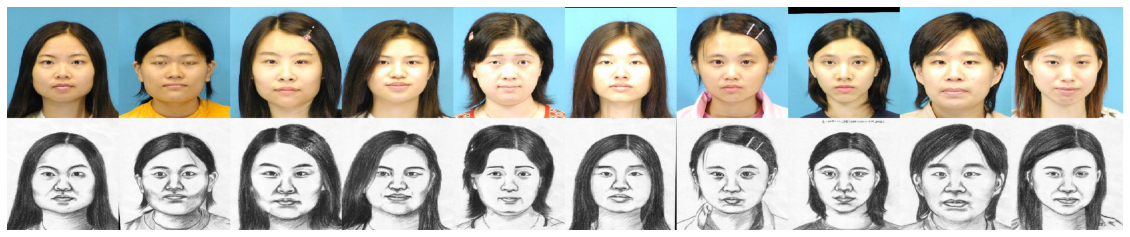

In [ ]:
some_photos = np.concatenate([i for i in x_train[0:10]],axis=1)
some_sketches = np.concatenate([i for i in y_train[0:10]],axis=1)
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([some_photos,some_sketches]))
plt.axis("OFF")
plt.show()

# DAE Model

In [ ]:
x_train_flatten = x_train.reshape(len(x_train), -1)
x_test_flatten = x_test.reshape(len(x_test), -1)
y_train_flatten = y_train.reshape(len(y_train), -1)
y_test_flatten = y_test.reshape(len(y_test), -1)
y_train_flatten.shape

(1166, 196608)

In [ ]:
import keras 
def dae_model(x_train_flatten, y_train_flatten):
    input_img = keras.Input(shape=(y_train_flatten.shape[1], ))
    enc_layer1 = keras.layers.Dense(1024, activation='ReLU')(input_img)
    enc_layer2 = keras.layers.Dense(512, activation='ReLU')(enc_layer1)
    enc_layer3 = keras.layers.Dense(256, activation='ReLU')(enc_layer2)
    enc_layer4 = keras.layers.Dense(128, activation='ReLU')(enc_layer3)
    enc_layer5 = keras.layers.Dense(64, activation='ReLU')(enc_layer4)
    bottleneck = keras.layers.Dense(32, activation='ReLU')(enc_layer5)

    dec_layer1 = keras.layers.Dense(64, activation='ReLU')(bottleneck)
    dec_layer2 = keras.layers.Dense(128, activation='ReLU')(dec_layer1)
    dec_layer3 = keras.layers.Dense(256, activation='ReLU')(dec_layer2)
    dec_layer4 = keras.layers.Dense(512, activation='ReLU')(dec_layer3)
    dec_layer5 = keras.layers.Dense(1024, activation='ReLU')(dec_layer4)
    dec_layer6 = keras.layers.Dense(y_train_flatten.shape[1], activation='sigmoid')(dec_layer5)

    # complete model 
    my_DAE = keras.Model(input_img, dec_layer6)
    # encoder 
    my_DAE_encoder = keras.Model(input_img, bottleneck)
    # decoder
    decoder_inp = keras.Input(shape=(32, ))
    decoder_layer = my_DAE.layers[-6](decoder_inp)
    decoder_layer = my_DAE.layers[-5](decoder_layer)
    decoder_layer = my_DAE.layers[-4](decoder_layer)
    decoder_layer = my_DAE.layers[-3](decoder_layer)
    decoder_layer = my_DAE.layers[-2](decoder_layer)
    decoder_layer = my_DAE.layers[-1](decoder_layer)
    my_DAE_decoder = keras.Model(decoder_inp, decoder_layer)

    return my_DAE, my_DAE_encoder, my_DAE_decoder


In [ ]:
my_DAE, my_DAE_encoder, my_DAE_decoder = dae_model(x_train_flatten, y_train_flatten)
my_DAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
checkpointer = ModelCheckpoint(filepath='best_ae.h5', verbose=0, save_best_only=True,
                               monitor="val_loss", mode="min")

hist = my_DAE.fit(x_train_flatten, y_train_flatten, 
           batch_size=64, 
           epochs=100,
           shuffle=True,
           callbacks=[checkpointer],
           validation_data=(x_test_flatten, y_test_flatten))

Epoch 1/100
19/19 [==============================] - 40s 2s/step - loss: 0.6380 - acc: 0.0000e+00 - val_loss: 0.4757 - val_acc: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 31s 2s/step - loss: 0.4606 - acc: 0.0000e+00 - val_loss: 0.4375 - val_acc: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 30s 2s/step - loss: 0.4539 - acc: 0.0000e+00 - val_loss: 0.4320 - val_acc: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 4s 190ms/step - loss: 0.4527 - acc: 0.0000e+00 - val_loss: 0.4323 - val_acc: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 4s 190ms/step - loss: 0.4512 - acc: 0.0000e+00 - val_loss: 0.4341 - val_acc: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 4s 214ms/step - loss: 0.4513 - acc: 0.0000e+00 - val_loss: 0.4326 - val_acc: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 4s 183ms/step - loss: 0.4489 - acc: 0.0000e+00 - val_loss: 0.4327 - val_acc: 0.0000e+00
Epoch 8/100
19/19 [

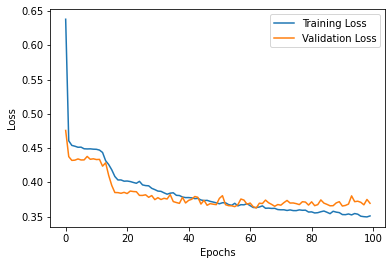

In [ ]:
plot_loss(hist)

5/5 [==============================] - 0s 17ms/step


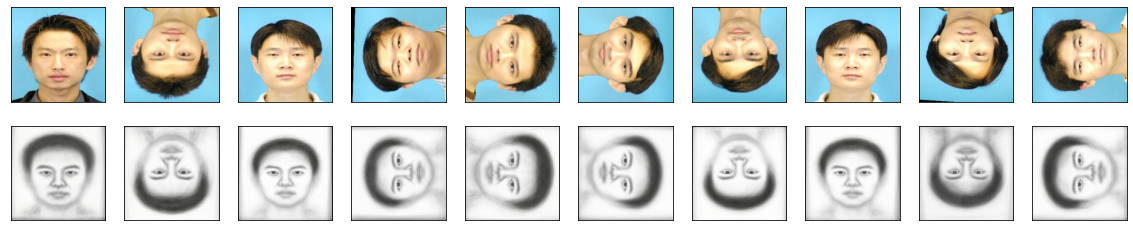

In [ ]:
best_DAE_model = keras.models.load_model("/content/best_ae.h5")
compare(best_DAE_model, x_test_flatten)

In [ ]:
my_DAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196608)]          0         
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080  

We can see that the loss error barely goes below some value. This is probably because we don't have enough samples to train this many of weights, thus resulting in a very slow training

In [ ]:
from skimage.metrics import structural_similarity as ssim

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
    mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    mse_error /= float(np.prod(imageA.shape))
      
    # return the MSE. The lower the error, the more "similar" the two images are.
    return mse_error

def compare_images(imageA, imageB):
    # Calculate the MSE and SSIM
    m = mse(imageA, imageB)

    if len(imageA.shape) == 3:
        s = ssim(imageA, imageB, multichannel=True)
    else:
        s = ssim(imageA, imageB)

    # Return the SSIM and MSE. The higher the value, the more "similar" the two images are.
    return m, s

def compute_scores(x_test, y_test, model):
    # compute similarity scores for the model
    mse_score, ssim_score = [], [] 
    y_hat = model.predict(x_test)
    for i in range(len(x_test)):
        m, s = compare_images(y_test[i], y_hat[i])
        mse_score.append(m)
        ssim_score.append(s)
    return mse_score, ssim_score

In [ ]:
mse_score, ssim_score = compute_scores(x_test_flatten, y_test_flatten, best_DAE_model)
print("Mean MSE for face2sketch task is :", np.average(mse_score))
print("Mean SSIM for face2sketch task is :", np.average(ssim_score))

5/5 [==============================] - 0s 28ms/step
Mean MSE for face2sketch task is : 0.03736176588366676
Mean SSIM for face2sketch task is : 0.8487096348109435


Now let's try this architecture on the sketch2face task.

In [ ]:
# change training and test sets 
x_train, x_test, y_train, y_test = get_data(augmentation=True, face2sketch=False)

x_train_flatten = x_train.reshape(len(x_train), -1)
x_test_flatten = x_test.reshape(len(x_test), -1)
y_train_flatten = y_train.reshape(len(y_train), -1)
y_test_flatten = y_test.reshape(len(y_test), -1)

my_DAE, my_DAE_encoder, my_DAE_decoder = dae_model(x_train_flatten, y_train_flatten)
my_DAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
checkpointer = ModelCheckpoint(filepath='best_ae_sketch2face.h5', verbose=0, save_best_only=True,
                               monitor="val_loss", mode="min")

hist = my_DAE.fit(x_train_flatten, y_train_flatten, 
           batch_size=64, 
           epochs=100,
           shuffle=True,
           callbacks=[checkpointer],
           validation_data=(x_test_flatten, y_test_flatten))

(1166, 256, 256, 3) (1166, 256, 256, 3) (130, 256, 256, 3) (130, 256, 256, 3)
Epoch 1/100
19/19 [==============================] - 40s 2s/step - loss: 0.6500 - acc: 0.0000e+00 - val_loss: 0.6106 - val_acc: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 31s 2s/step - loss: 0.6231 - acc: 8.5763e-04 - val_loss: 0.5931 - val_acc: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 30s 2s/step - loss: 0.6221 - acc: 0.0000e+00 - val_loss: 0.5922 - val_acc: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 30s 2s/step - loss: 0.6217 - acc: 0.0000e+00 - val_loss: 0.5818 - val_acc: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 30s 2s/step - loss: 0.6092 - acc: 8.5763e-04 - val_loss: 0.5782 - val_acc: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 31s 2s/step - loss: 0.5988 - acc: 8.5763e-04 - val_loss: 0.5676 - val_acc: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 3s 175ms/step - loss: 0.6057 - acc:

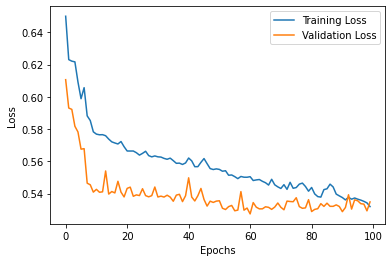

In [ ]:
plot_loss(hist)

5/5 [==============================] - 0s 16ms/step


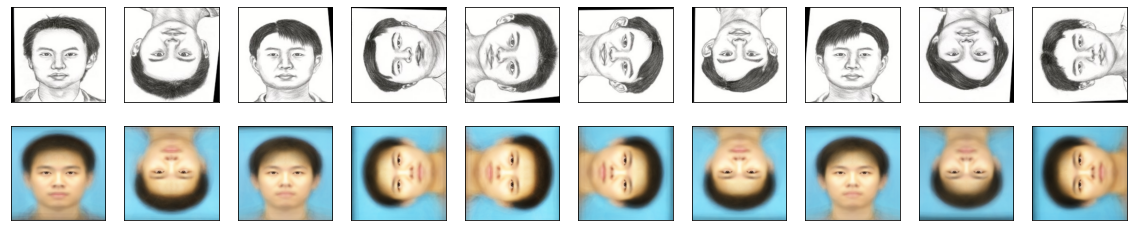

In [ ]:
best_DAE_sketch2face_model = keras.models.load_model("/content/best_ae_sketch2face.h5")
compare(best_DAE_sketch2face_model, x_test_flatten)

In [ ]:
mse_score, ssim_score = compute_scores(x_test_flatten, y_test_flatten, best_DAE_sketch2face_model)
print("Mean MSE for sketch2face task is :", np.average(mse_score))
print("Mean SSIM for sketch2face task is :", np.average(ssim_score))

5/5 [==============================] - 0s 19ms/step
Mean MSE for sketch2face task is : 0.02067158380748103
Mean SSIM for sketch2face task is : 0.8521342440208554


# CAE model

In [ ]:
x_train.shape

(1166, 256, 256, 3)

In [ ]:
def compare(model, x_test):
    decoded_img = model.predict(x_test)

    n = 10  # How many images we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(SIZE, SIZE, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_img[i].reshape(SIZE, SIZE, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
SIZE = 256
def cae_model():
    input_img = keras.Input(shape=(SIZE,SIZE,3))
    c1 = Conv2D(32, 3, activation="relu", padding="same")(input_img)
    c1 = Conv2D(32, 3, activation="relu", padding="same")(c1)
    m1 = MaxPooling2D(2)(c1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(m1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(c2)
    m2 = MaxPooling2D(2)(c2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(m2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(c3)
    m3 = MaxPooling2D(2)(c3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(m3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(c4)

    u1 = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(c4)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(u1)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(c5)
    a1 = add([c5,c3])
    u2 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(a1)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(u2)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(c6)
    a2 = add([c6,c2])
    u3 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(a2)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(u3)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(c7)
    a3 = add([c7,c1])
    out = Conv2D(3, 3, activation="sigmoid", padding="same")(a3)

    model = Model(input_img, out)
    return model



In [ ]:
cae = cae_model()
cae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
cae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
            loss="binary_crossentropy", metrics=['acc'])

In [ ]:
from keras import callbacks
# earlystopping = callbacks.EarlyStopping(monitor="val_loss",
#                                         mode="min", patience=5,
#                                         restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath='best_ca.h5', verbose=0, save_best_only=True,
                               monitor="val_loss", mode="min")

# x_train, x_test, y_train, y_test = get_data(augmentation=True, face2sketch=True)

hist = cae.fit(x_train, y_train, epochs = 100, 
                 validation_data=(x_test, y_test), batch_size=64,      
                    callbacks=[checkpointer])

Epoch 1/100
19/19 [==============================] - 42s 1s/step - loss: 0.4677 - acc: 0.4354 - val_loss: 0.3975 - val_acc: 0.6716
Epoch 2/100
19/19 [==============================] - 19s 1s/step - loss: 0.4017 - acc: 0.4509 - val_loss: 0.3940 - val_acc: 0.3782
Epoch 3/100
19/19 [==============================] - 20s 1s/step - loss: 0.3922 - acc: 0.4572 - val_loss: 0.3844 - val_acc: 0.3237
Epoch 4/100
19/19 [==============================] - 20s 1s/step - loss: 0.3843 - acc: 0.3587 - val_loss: 0.3793 - val_acc: 0.1972
Epoch 5/100
19/19 [==============================] - 19s 1s/step - loss: 0.3753 - acc: 0.4587 - val_loss: 0.3742 - val_acc: 0.2553
Epoch 6/100
19/19 [==============================] - 19s 1s/step - loss: 0.3690 - acc: 0.4580 - val_loss: 0.3710 - val_acc: 0.3723
Epoch 7/100
19/19 [==============================] - 19s 1s/step - loss: 0.3653 - acc: 0.4099 - val_loss: 0.3711 - val_acc: 0.1827
Epoch 8/100
19/19 [==============================] - 20s 1s/step - loss: 0.3642 - a

In [ ]:
best_cae_model = keras.models.load_model("/content/best_ca.h5")

5/5 [==============================] - 1s 152ms/step


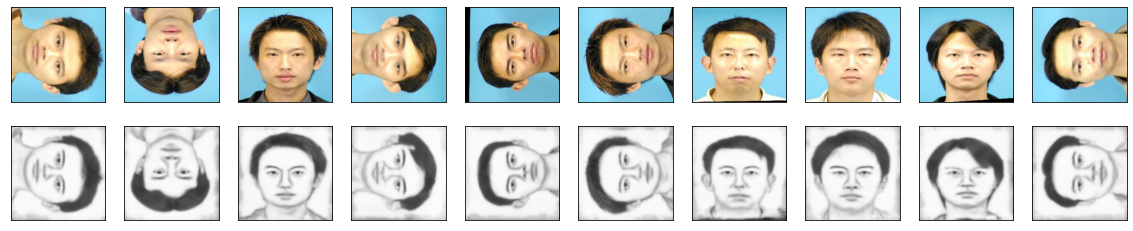

In [ ]:
compare(best_cae_model, x_test)

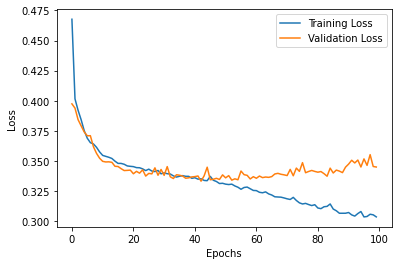

In [ ]:
plot_loss(hist)

In [ ]:
mse_score, ssim_score = compute_scores(x_test, y_test, best_cae_model)
print("Mean MSE for sketch2face task is :", np.average(mse_score))
print("Mean SSIM for sketch2face task is :", np.average(ssim_score))

5/5 [==============================] - 1s 151ms/step


<ipython-input-31-547446369cfd>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s = ssim(imageA, imageB, multichannel=True)


Mean MSE for sketch2face task is : 0.0278664140655034
Mean SSIM for sketch2face task is : 0.7706145


1/1 [==============================] - 1s 848ms/step


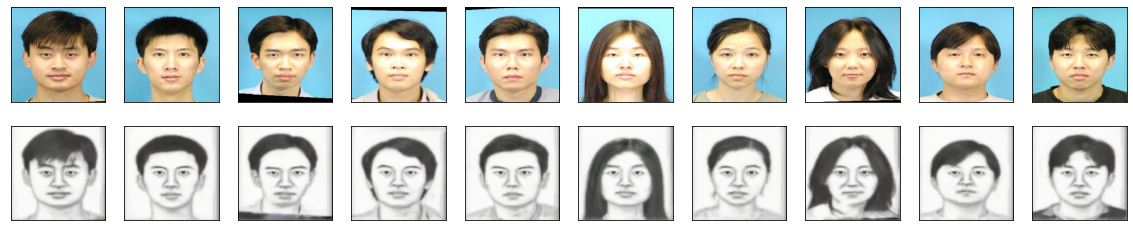

In [ ]:
compare(best_cae_model, x_test)

Another CAE model with MSE error.

In [ ]:
cae_mse = cae_model()
cae.compile(optimizer="adam",loss="mean_squared_error", 
            metrics=['acc'])
checkpointer = ModelCheckpoint(filepath='best_mse.h5', verbose=0, save_best_only=True,
                               monitor="val_loss", mode="min")

hist = cae.fit(x_train, y_train, epochs = 1000, 
                 validation_data=(x_test, y_test), batch_size=64,      
                    callbacks=[checkpointer])

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_mse.h5', verbose=0, save_best_only=True,
                               monitor="val_acc", mode="max")

hist = cae.fit(x_train, y_train, epochs = 1000, 
                 validation_data=(x_test, y_test), batch_size=64,      
                    callbacks=[checkpointer])

Epoch 1/1000
3/3 [==============================] - 10s 844ms/step - loss: 0.0177 - acc: 0.6522 - val_loss: 0.0295 - val_acc: 0.6316
Epoch 2/1000
3/3 [==============================] - 2s 642ms/step - loss: 0.0172 - acc: 0.6632 - val_loss: 0.0298 - val_acc: 0.7296
Epoch 3/1000
3/3 [==============================] - 2s 603ms/step - loss: 0.0169 - acc: 0.7421 - val_loss: 0.0294 - val_acc: 0.7025
Epoch 4/1000
3/3 [==============================] - 2s 539ms/step - loss: 0.0172 - acc: 0.6897 - val_loss: 0.0293 - val_acc: 0.5717
Epoch 5/1000
3/3 [==============================] - 2s 664ms/step - loss: 0.0172 - acc: 0.5310 - val_loss: 0.0289 - val_acc: 0.4245
Epoch 6/1000
3/3 [==============================] - 2s 631ms/step - loss: 0.0169 - acc: 0.3894 - val_loss: 0.0286 - val_acc: 0.3426
Epoch 7/1000
3/3 [==============================] - 2s 626ms/step - loss: 0.0168 - acc: 0.3294 - val_loss: 0.0288 - val_acc: 0.3306
Epoch 8/1000
3/3 [==============================] - 2s 546ms/step - loss: 0

In [ ]:
best_cae_mse_model = keras.models.load_model("/content/best_mse.h5")

1/1 [==============================] - 0s 288ms/step


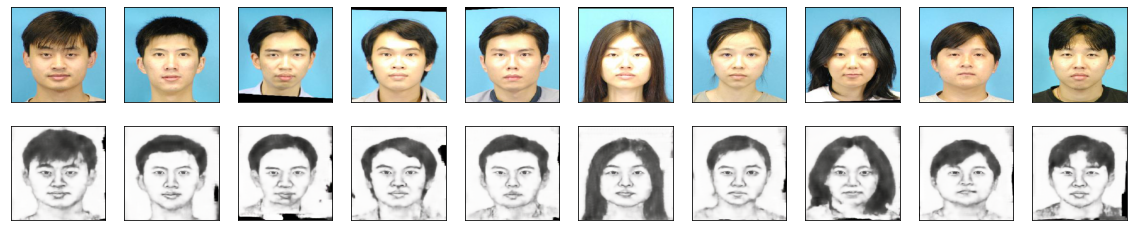

In [ ]:
compare(best_cae_mse_model, x_test)

1/1 [==============================] - 0s 37ms/step


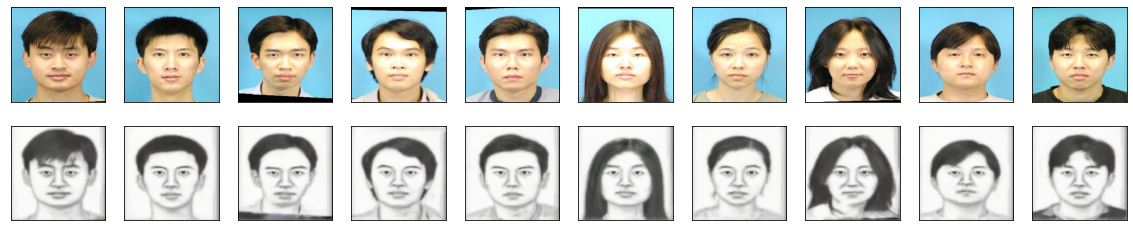

In [ ]:
compare(best_cae_model, x_test)

In [ ]:
from sklearn.metrics import mean_squared_error
yhat_mse = best_cae_mse_model.predict(x_test)
yhat = best_cae_model.predict(x_test)
print('Model MSE on test data = ', np.square(np.subtract(y_test, yhat_mse)).mean())
print('Model on test data = ', np.square(np.subtract(y_test, yhat)).mean())


1/1 [==============================] - 0s 64ms/step
Model MSE on test data =  0.03449824
Model on test data =  0.027075378


# Sketch2Face
Given the last CAE model, we will swap the input and output and check the performance.

In [ ]:
x_train, x_test, y_train, y_test = get_data(augmentation=True, face2sketch=False)

(1166, 256, 256, 3) (1166, 256, 256, 3) (130, 256, 256, 3) (130, 256, 256, 3)


In [ ]:
cae.compile(optimizer="adam",loss="binary_crossentropy", metrics=['acc'])
checkpointer = ModelCheckpoint(filepath='best_cae_sketch2face.h5', verbose=0, save_best_only=True,
                               monitor="val_loss", mode="min")

hist = cae.fit(x_train, y_train, epochs = 100, 
                 validation_data=(x_test, y_test), batch_size=64,      
                    callbacks=[checkpointer])

Epoch 1/100
19/19 [==============================] - 26s 1s/step - loss: 0.6126 - acc: 0.0648 - val_loss: 0.5693 - val_acc: 0.0534
Epoch 2/100
19/19 [==============================] - 19s 1s/step - loss: 0.5872 - acc: 0.1482 - val_loss: 0.5664 - val_acc: 0.2100
Epoch 3/100
19/19 [==============================] - 19s 1s/step - loss: 0.5851 - acc: 0.2097 - val_loss: 0.5628 - val_acc: 0.2024
Epoch 4/100
19/19 [==============================] - 20s 1s/step - loss: 0.5806 - acc: 0.3294 - val_loss: 0.5480 - val_acc: 0.4764
Epoch 5/100
19/19 [==============================] - 20s 1s/step - loss: 0.5656 - acc: 0.6561 - val_loss: 0.5313 - val_acc: 0.8630
Epoch 6/100
19/19 [==============================] - 19s 1s/step - loss: 0.5529 - acc: 0.8496 - val_loss: 0.5223 - val_acc: 0.8817
Epoch 7/100
19/19 [==============================] - 20s 1s/step - loss: 0.5452 - acc: 0.8753 - val_loss: 0.5180 - val_acc: 0.9003
Epoch 8/100
19/19 [==============================] - 20s 1s/step - loss: 0.5444 - a

5/5 [==============================] - 1s 154ms/step


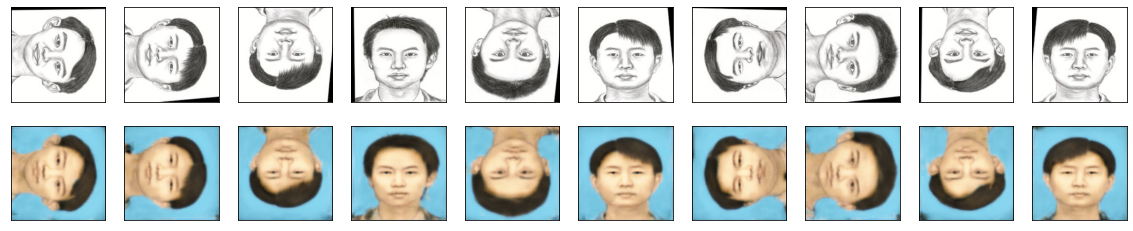

In [ ]:
best_cae_sketch2face_model = keras.models.load_model("/content/best_cae_sketch2face.h5")
compare(best_cae_sketch2face_model, x_test)

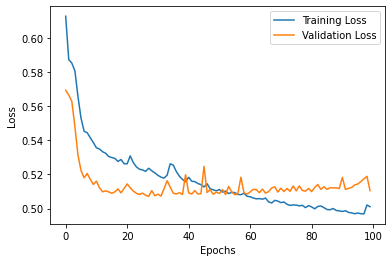

In [ ]:
plot_loss(hist)

In [ ]:
mse_score, ssim_score = compute_scores(x_test, y_test, best_cae_model)
print("Mean MSE for sketch2face task is :", np.average(mse_score))
print("Mean SSIM for sketch2face task is :", np.average(ssim_score))

5/5 [==============================] - 1s 153ms/step


<ipython-input-31-547446369cfd>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s = ssim(imageA, imageB, multichannel=True)


Mean MSE for sketch2face task is : 0.07297474704909539
Mean SSIM for sketch2face task is : 0.6799017
